# Recurrent Neural Networks

* [Ultimate Guide to Recurrent Neural Networks](https://www.superdatascience.com/blogs/the-ultimate-guide-to-recurrent-neural-networks-rnn)
* Used for `Time Series` data analysis
* Weights like in ANNs represent long-term memory
  * Similar to the temporal lobe of the brain
* RNNs are like short-term memory
  * Similar to the frontal lobe of the brain
* Can be thought of as a ANN squashed together (or looking from another dimension) and inverted with a temporal loop with in the hidden layer
  * Temporal loop meaning it feeds data back into itself in addition to the output
  * Each blue circle representing a whole layer of neurons <img src="img/41_blog_image_10.png">
* Types of RNNs
  * 1:Many - One input and many outputs
    * e.g. An image input with a descriptive output of the image. "black and white dog jumps over bar"
  * Many:1 - Many inputs and one output
    * e.g. Sentiment analysis. "Thanks for a great party!" - positive score: 86%
  * Many:Many - Many inputs to many outputs
    * e.g. Google translator to maintain gender specific information
    * e.g. Movie subtitles - need context to understand plot
* `Vanishing gradient problem`
  * As weights are updated backward through the network if the value (error) being applied to the weights (Wrec) is too small then the weights get too small to be relevant (vanishign) or if too big then the weights get too large (exploding) and invalidates the entire network
* `Long short-term memory` (LSTM)
  *  Solution to vanishing gradient problem <img src="img/41_blog_image_22.png" >
  *  pointwise operations are like valves (X) controlled by neural network layers
     *  forget valve
     *  memory valve
     *  output valve
  *  neural network layer
     *  sigmoid
     *  tanh
  *  Variations
     *  Peep-hole - adding additional information to neural network layers (sigmoid)
     *  Combine decisioning between valves
     *  Gated recurring units (GRUs)
  *  Reading
     *  [LSTM: A Search Space Odyssey](https://arxiv.org/pdf/1503.04069.pdf) by Klaus Greff et al. (2015) 

## A stacked LSTM model with Dropout Regularization

In [1]:
from os.path import dirname, abspath, join, curdir

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Data preprocessing

In [ ]:
# Get new ticker data if needed

# import yfinance as yf
# spy = yf.Ticker("SPY")
# spy.info

# data = spy.history(period="10y", interval="1d")
# data.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
# data.to_csv(join(dirname(dirname(abspath(curdir))), "data", "raw", "rnn", "spy_stock_prices_10y.csv"))

In [2]:
# Import the training set
datapath = join(dirname(dirname(abspath(curdir))), "data", "raw", "rnn")

dataset_train = pd.read_csv(join(datapath, "spy_stock_prices_10y.csv"))
train_set = dataset_train.iloc[:, 1:2].values
train_set, train_set.shape

(array([[140.77774359],
        [142.46747874],
        [141.88480495],
        ...,
        [459.01998901],
        [455.88000488],
        [457.41000366]]),
 (2486, 1))

In [3]:
# Apply recommended normalization scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1), copy=True)
train_set_scaled = sc.fit_transform(train_set) # Fit with data min/max then transforms
train_set_scaled, train_set_scaled.size

(array([[0.00637331],
        [0.01150368],
        [0.00973456],
        ...,
        [0.97261928],
        [0.96308567],
        [0.96773104]]),
 2486)

In [4]:
# Create data structure with 60 timesteps (past info) and 1 output
X_train = []
y_train = []

for i in range(60, train_set_scaled.size):
    X_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [5]:
X_train

array([[0.00637331, 0.01150368, 0.00973456, ..., 0.033776  , 0.03456326,
        0.03776281],
       [0.01150368, 0.00973456, 0.01112449, ..., 0.03456326, 0.03776281,
        0.03979455],
       [0.00973456, 0.01112449, 0.01746783, ..., 0.03776281, 0.03979455,
        0.03855025],
       ...,
       [0.8357245 , 0.83360705, 0.82329193, ..., 0.95546478, 0.95713475,
        0.95880462],
       [0.83360705, 0.82329193, 0.80989133, ..., 0.95713475, 0.95880462,
        0.97261928],
       [0.82329193, 0.80989133, 0.81588084, ..., 0.95880462, 0.97261928,
        0.96308567]])

In [6]:
y_train

array([0.03979455, 0.03855025, 0.03814399, ..., 0.97261928, 0.96308567,
       0.96773104])

In [7]:
# Reshaping to add new dimension to train data, the new dimension can be any 
# number of additional indicators but for now all we're using is the open price
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train, X_train.shape

(array([[[0.00637331],
         [0.01150368],
         [0.00973456],
         ...,
         [0.033776  ],
         [0.03456326],
         [0.03776281]],
 
        [[0.01150368],
         [0.00973456],
         [0.01112449],
         ...,
         [0.03456326],
         [0.03776281],
         [0.03979455]],
 
        [[0.00973456],
         [0.01112449],
         [0.01746783],
         ...,
         [0.03776281],
         [0.03979455],
         [0.03855025]],
 
        ...,
 
        [[0.8357245 ],
         [0.83360705],
         [0.82329193],
         ...,
         [0.95546478],
         [0.95713475],
         [0.95880462]],
 
        [[0.83360705],
         [0.82329193],
         [0.80989133],
         ...,
         [0.95713475],
         [0.95880462],
         [0.97261928]],
 
        [[0.82329193],
         [0.80989133],
         [0.81588084],
         ...,
         [0.95880462],
         [0.97261928],
         [0.96308567]]]),
 (2426, 60, 1))

### Building the RNN

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2023-09-12 15:53:54.410741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Initialize the RNN
rnn = Sequential()

In [10]:
# Add the first LSTM layer with dropout regularization to prevent overfitting

# units = # of neurons, need high dimensionality to capture upward/downward trends
# return_sequences = True when there will be multiple LSTM layers
rnn.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn.add(Dropout(0.2)) # ignore 20% of neurons during each training iteration

In [11]:
# Add second LSTM/Dropout layers
rnn.add(LSTM(units=50, return_sequences=True))
rnn.add(Dropout(0.2))

# Add third LSTM/Dropout layers
rnn.add(LSTM(units=50, return_sequences=True))
rnn.add(Dropout(0.2))

# Add fourth LSTM/Dropout layers
rnn.add(LSTM(units=50))
rnn.add(Dropout(0.2))

In [12]:
# Add the output layer
rnn.add(Dense(units=1))

In [13]:
# Compile the RNN
rnn.compile(optimizer="adam", loss="mean_squared_error")

In [14]:
# Fitting the RNN to the training set
rnn.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
76/76 [==============================] - 11s 58ms/step - loss: 0.0189
Epoch 2/100
76/76 [==============================] - 5s 59ms/step - loss: 0.0035
Epoch 3/100
76/76 [==============================] - 4s 57ms/step - loss: 0.0031
Epoch 4/100
76/76 [==============================] - 4s 53ms/step - loss: 0.0030
Epoch 5/100
76/76 [==============================] - 4s 52ms/step - loss: 0.0028
Epoch 6/100
76/76 [==============================] - 4s 52ms/step - loss: 0.0028
Epoch 7/100
76/76 [==============================] - 4s 53ms/step - loss: 0.0032
Epoch 8/100
76/76 [==============================] - 4s 52ms/step - loss: 0.0025
Epoch 9/100
76/76 [==============================] - 5s 62ms/step - loss: 0.0026
Epoch 10/100
76/76 [==============================] - 5s 62ms/step - loss: 0.0023
Epoch 11/100
76/76 [==============================] - 4s 54ms/step - loss: 0.0022
Epoch 12/100
76/76 [==============================] - 4s 55ms/step - loss: 0.0019
Epoch 13/100
76/76 [====

### Prediction and visualization

In [17]:
# Save model to models directory
model_path = join(dirname(dirname(abspath(curdir))), "models")
rnn.save(join(model_path, "rnn_spy_10y.keras"))

In [15]:
# Load test data
dataset_test = pd.read_csv(join(datapath, "spy_stock_prices_08-2023.csv"))
stock_open_prices = dataset_test.iloc[:, 1:2].values

In [20]:
# Prepend the last 60 days of Open prices to test data
# NOTE: Its important to ensure the test data isn't feature scaled with any already scaled training data
# as this introduces data leaks and protential overfitting
dataset_total = pd.concat((dataset_train.Open, dataset_test.Open), axis=0)
inputs = dataset_total.iloc[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [21]:
X_test = []

for i in range(60, inputs.size):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
pred = rnn.predict(X_test)
predicted_stock_price = sc.inverse_transform(pred)

1/1 [==============================] - 1s 1s/step


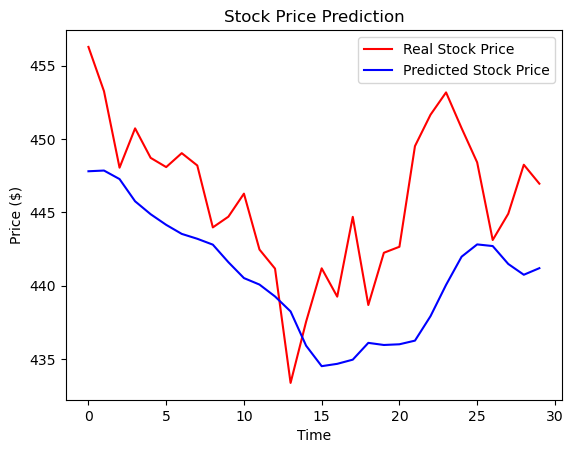

In [25]:
# Visualising the results
plt.plot(stock_open_prices, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()